# Identifying emerging topics in grants using 'concepts'

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) in order to extract [concepts](https://docs.dimensions.ai/dsl/language.html#searching-using-concepts) from grants data and use them as the basis for more advanced topic analyses tasks. 

**Note** this tutorial is best experienced using Google Colab. 

In [1]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 25, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).


In [2]:
!pip install dimcli plotly wordcloud -U --quiet 

import dimcli
from dimcli.utils import *

import json, sys
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import plotly.express as px  # plotly>=4.8.1
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


## 1. Creating a Dataset: e.g. Grants from a Funder 

The dataset we'll be using in this tutorial contains grants from the [National Science Foundation](https://www.grid.ac/institutes/grid.431093.c). 

By using the parameters below, we can restrict the dataset further using dates (start year of a grant) and a subject area (field of research code). 

After extracting the grants records, we are going to use the `as_dataframe_concepts` method to unpack concepts/scores data into a format that makes it easier to analyse it. For more background, see also the [Working with concepts in the Dimensions API](https://api-lab.dimensions.ai/cookbooks/1-getting-started/7-Working-with-concepts.html) tutorial.

In [3]:
#@markdown ## Define the criteria for extracting grants

#@markdown A GRID organization from https://grid.ac/institutes
GRIDID = "grid.431093.c" #@param {type:"string"}

#@markdown The start_year range for the grants
YEAR_START = 2000 #@param {type: "slider", min: 1950, max: 2020}
YEAR_END = 2020 #@param {type: "slider", min: 1950, max: 2020}

#@markdown The Field Of Research (FOR) category (None = all)
CATEGORY = "None"  #@param ['None', '0101 Pure Mathematics', '0102 Applied Mathematics', '0103 Numerical and Computational Mathematics', '0104 Statistics', '0105 Mathematical Physics', '0201 Astronomical and Space Sciences', '0202 Atomic, Molecular, Nuclear, Particle and Plasma Physics', '0203 Classical Physics', '0204 Condensed Matter Physics', '0205 Optical Physics', '0206 Quantum Physics', '0299 Other Physical Sciences', '0301 Analytical Chemistry', '0302 Inorganic Chemistry', '0303 Macromolecular and Materials Chemistry', '0304 Medicinal and Biomolecular Chemistry', '0305 Organic Chemistry', '0306 Physical Chemistry (incl. Structural)', '0307 Theoretical and Computational Chemistry', '0399 Other Chemical Sciences', '0401 Atmospheric Sciences', '0402 Geochemistry', '0403 Geology', '0404 Geophysics', '0405 Oceanography', '0406 Physical Geography and Environmental Geoscience', '0499 Other Earth Sciences', '0501 Ecological Applications', '0502 Environmental Science and Management', '0503 Soil Sciences', '0599 Other Environmental Sciences', '0601 Biochemistry and Cell Biology', '0602 Ecology', '0603 Evolutionary Biology', '0604 Genetics', '0605 Microbiology', '0606 Physiology', '0607 Plant Biology', '0608 Zoology', '0699 Other Biological Sciences', '0701 Agriculture, Land and Farm Management', '0702 Animal Production', '0703 Crop and Pasture Production', '0704 Fisheries Sciences', '0705 Forestry Sciences', '0706 Horticultural Production', '0707 Veterinary Sciences', '0799 Other Agricultural and Veterinary Sciences', '0801 Artificial Intelligence and Image Processing', '0802 Computation Theory and Mathematics', '0803 Computer Software', '0804 Data Format', '0805 Distributed Computing', '0806 Information Systems', '0807 Library and Information Studies', '0899 Other Information and Computing Sciences', '0901 Aerospace Engineering', '0902 Automotive Engineering', '0903 Biomedical Engineering', '0904 Chemical Engineering', '0905 Civil Engineering', '0906 Electrical and Electronic Engineering', '0907 Environmental Engineering', '0908 Food Sciences', '0909 Geomatic Engineering', '0910 Manufacturing Engineering', '0911 Maritime Engineering', '0912 Materials Engineering', '0913 Mechanical Engineering', '0914 Resources Engineering and Extractive Metallurgy', '0915 Interdisciplinary Engineering', '0999 Other Engineering', '1001 Agricultural Biotechnology', '1002 Environmental Biotechnology', '1003 Industrial Biotechnology', '1004 Medical Biotechnology', '1005 Communications Technologies', '1006 Computer Hardware', '1007 Nanotechnology', '1099 Other Technology', '1101 Medical Biochemistry and Metabolomics', '1102 Cardiorespiratory Medicine and Haematology', '1103 Clinical Sciences', '1104 Complementary and Alternative Medicine', '1105 Dentistry', '1106 Human Movement and Sports Science', '1107 Immunology', '1108 Medical Microbiology', '1109 Neurosciences', '1110 Nursing', '1111 Nutrition and Dietetics', '1112 Oncology and Carcinogenesis', '1113 Ophthalmology and Optometry', '1114 Paediatrics and Reproductive Medicine', '1115 Pharmacology and Pharmaceutical Sciences', '1116 Medical Physiology', '1117 Public Health and Health Services', '1199 Other Medical and Health Sciences', '1201 Architecture', '1202 Building', '1203 Design Practice and Management', '1205 Urban and Regional Planning', '1299 Other Built Environment and Design', '1301 Education Systems', '1302 Curriculum and Pedagogy', '1303 Specialist Studies In Education', '1399 Other Education', '1401 Economic Theory', '1402 Applied Economics', '1403 Econometrics', '1499 Other Economics', '1501 Accounting, Auditing and Accountability', '1502 Banking, Finance and Investment', '1503 Business and Management', '1504 Commercial Services', '1505 Marketing', '1506 Tourism', '1507 Transportation and Freight Services', '1601 Anthropology', '1602 Criminology', '1603 Demography', '1604 Human Geography', '1605 Policy and Administration', '1606 Political Science', '1607 Social Work', '1608 Sociology', '1699 Other Studies In Human Society', '1701 Psychology', '1702 Cognitive Sciences', '1799 Other Psychology and Cognitive Sciences', '1801 Law', '1899 Other Law and Legal Studies', '1901 Art Theory and Criticism', '1902 Film, Television and Digital Media', '1903 Journalism and Professional Writing', '1904 Performing Arts and Creative Writing', '1905 Visual Arts and Crafts', '1999 Other Studies In Creative Arts and Writing', '2001 Communication and Media Studies', '2002 Cultural Studies', '2003 Language Studies', '2004 Linguistics', '2005 Literary Studies', '2099 Other Language, Communication and Culture', '2101 Archaeology', '2102 Curatorial and Related Studies', '2103 Historical Studies', '2199 Other History and Archaeology', '2201 Applied Ethics', '2202 History and Philosophy of Specific Fields', '2203 Philosophy', '2204 Religion and Religious Studies', '2299 Other Philosophy and Religious Studies']
    
if YEAR_END < YEAR_START:
  YEAR_END = YEAR_START


# subject area query component
if CATEGORY == "None":
  subject_area_q =  ""
else:
  subject_area_q = f""" and category_for.name="{CATEGORY}" """

print(f"""You selected:\n->{GRIDID}\n->{YEAR_START}-{YEAR_END}\n->{CATEGORY}""") 

from IPython.core.display import display, HTML
display(HTML('-><br /><a href="{}">Preview {} in Dimensions.ai &#x29c9;</a>'.format(dimensions_url(GRIDID), GRIDID)))

You selected:
->grid.431093.c
->2000-2020
->None


Let's build an API query and run it now

In [4]:
query = f"""
search grants 
    where research_orgs.id = "{GRIDID}"
    and start_year in [{YEAR_START}:{YEAR_END}]
    {subject_area_q} 
    return grants[id+concepts_scores+start_year+category_for]
"""
    

print("===\nQuery:\n", query)     
print("===\nRetrieving grants.. ")
data = dsl.query_iterative(query)

print("===\nExtracting Concepts.. ")
concepts = data.as_dataframe_concepts()

# method to keep only the 2 digits FOR category
def get_2_digits_cat(llist):
    if type(llist) == list:
        for d in llist:
            if len(d['name'].split()[0]) == 2:
                return d['name']
    return ""
concepts['for_first'] = concepts['category_for'].apply(lambda x: get_2_digits_cat(x))

concepts_unique = concepts.drop_duplicates("concept")[['concept', 'frequency', 'score_avg']]
concepts_unique_in_for = concepts.drop_duplicates(subset=["concept", "for_first"])[['concept', 'frequency', 'score_avg', 'for_first']]


print("==> Concepts Found (total):", len(concepts))
print("==> Unique Concepts Found:", len(concepts_unique))
print("==> Unique Concepts in FOR category Found:", len(concepts_unique_in_for))
print("==> Concepts with frequency major than 1:", len(concepts_unique.query("frequency > 1")))
print("===\nFOR categories:")
print(concepts_unique_in_for['for_first'].value_counts())

Starting iteration with limit=1000 skip=0 ...


===
Query:
 
search grants 
    where research_orgs.id = "grid.431093.c"
    and start_year in [2000:2020]
     
    return grants[id+concepts_scores+start_year+category_for]

===
Retrieving grants.. 


0-157 / 157 (1.33s)
===
Records extracted: 157


===
Extracting Concepts.. 
==> Concepts Found (total): 6336
==> Unique Concepts Found: 3492
==> Unique Concepts in FOR category Found: 4844
==> Concepts with frequency major than 1: 931
===
FOR categories:
04 Earth Sciences                                1353
06 Biological Sciences                            673
01 Mathematical Sciences                          448
08 Information and Computing Sciences             376
05 Environmental Sciences                         373
16 Studies in Human Society                       325
11 Medical and Health Sciences                    204
                                                  183
03 Chemical Sciences                              169
09 Engineering                                    166
02 Physical Sciences                              155
20 Language, Communication and Culture            137
17 Psychology and Cognitive Sciences               92
10 Technology                                      65
15 Commerce, Management, Tourism and S

## 2. A first look at the concepts we extracted

The goal of this section is understanding what are the best settings to use, in order to extract useful concepts. 

You selected:
->200
->2-70
->0.4


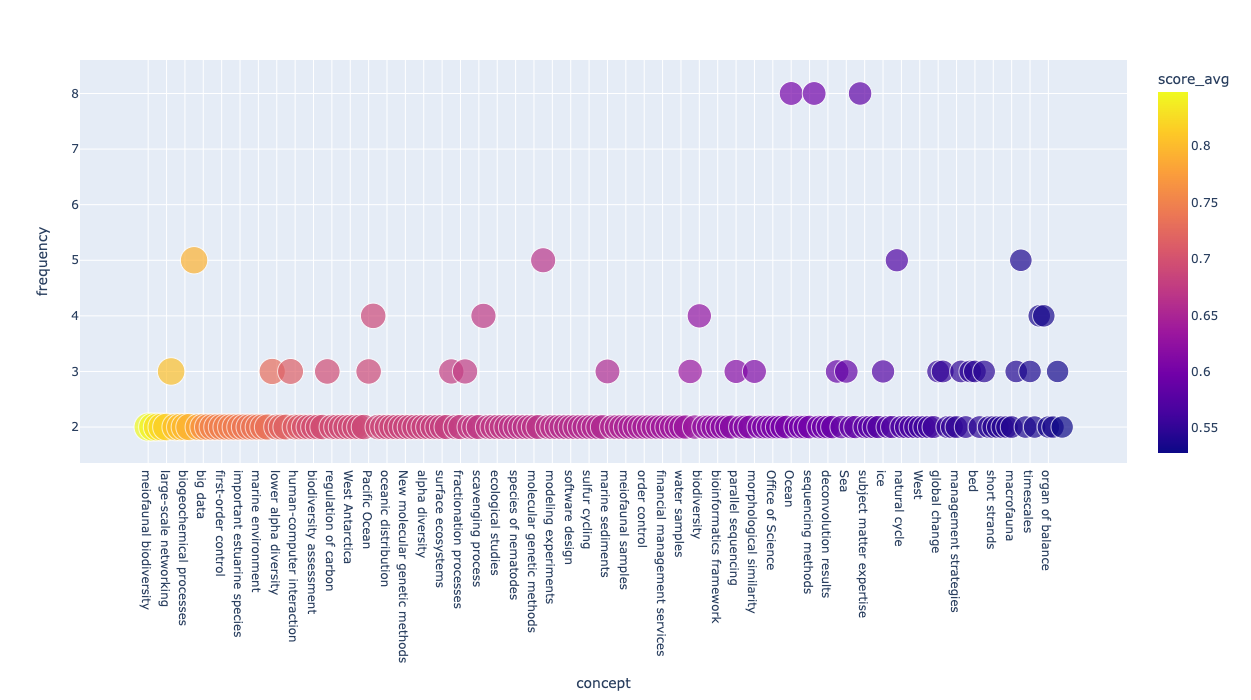

In [5]:
#@markdown ## Define the best parameters to isolate 'interesting' concepts
#@markdown Frequency: how many documents include a concept (100 = no upper limit). 
#@markdown Tip: concepts with very high frequencies tend to be common words, so it is useful to exclude them. 
FREQ_MIN = 2 #@param {type: "slider", min: 1, max: 10, step:1}
FREQ_MAX = 70 #@param {type: "slider", min: 10, max: 100, step:10}
#@markdown ---
#@markdown Score: the average relevancy score of concepts, for the dataset we extracted above.
#@markdown This value tends to be a good indicator of 'interesting' concepts.
SCORE_MIN = 0.4  #@param {type: "slider", min: 0, max: 1, step:0.1}
#@markdown ---
#@markdown Select how many concepts to include in the visualization 
MAX_CONCEPTS = 200 #@param {type: "slider", min: 20, max: 1000, step:10}

if FREQ_MAX == 100:
  FREQ_MAX = 100000000
print(f"""You selected:\n->{MAX_CONCEPTS}\n->{FREQ_MIN}-{FREQ_MAX}\n->{SCORE_MIN}""") 

filtered_concepts = concepts_unique.query(f"""frequency >= {FREQ_MIN} & frequency <= {FREQ_MAX} & score_avg >= {SCORE_MIN} """)\
                    .sort_values(["score_avg", "frequency"], ascending=False)[:MAX_CONCEPTS]

px.scatter(filtered_concepts, 
           x="concept", 
           y="frequency", 
           height=700,
           color="score_avg", 
           size="score_avg")

## 3. Building a word-cloud visualization

Wordclouds are often a pretty effective way of summarising the relative importance of keywords. The [wordcloud Python library](https://github.com/amueller/word_cloud) can be used to turn our concepts list into an image. The Wordcloud function takes a list of dictionaries with words/frequency eg

```
# [
#    {'concept': 'study', 'frequency': 5707},
#    {'concept': 'patients', 'frequency': 3579}
#   ... etc... 
#. ]
```

We can obtain that easily from the DSL concepts data:

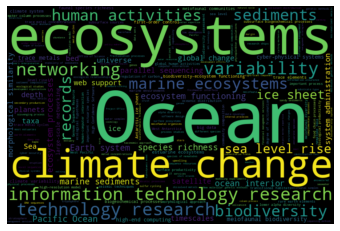

In [6]:
# take top N concepts
topn = filtered_concepts[['concept', 'frequency']][:300]

d = {x['concept'] : x['frequency'] for x in topn.to_dict(orient="records")}

wordcloud = WordCloud(width=900, height=600).generate_from_frequencies(d)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("topics_wordcloud.png", dpi=300)

## 4. Trend analysis - 'emerging' new topics each year

In this section we will look at the concept distribution over the years. In particular, we will focus on the 'new' concepts in each year - i.e. concepts that have never appeared in previous years. 

This can be easily achieved by adding a new column `first_year`, marking the earliest publication year a concept was found in. 

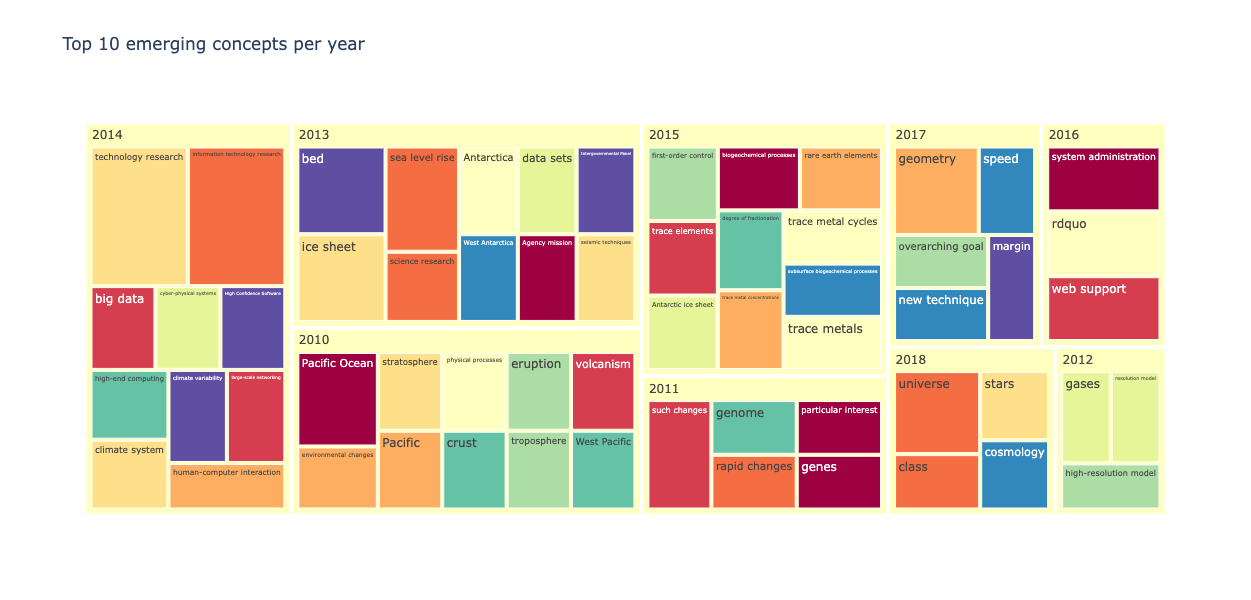

In [7]:
# enrich initial dataframe by adding 'first_year' 
concepts["first_year"] = concepts.groupby('concept')['start_year'].transform('min')
concepts_unique = concepts.drop_duplicates("concept")[['concept', 'frequency', 'score_avg', 'first_year']]

#@markdown ## Emerging concepts: parameters
#@markdown Start year of the publications/concepts to include
YEAR_START = 2010 #@param {type:"integer"}

#@markdown How many 'emerging' concepts to retain, for each year
CONCEPTS_PER_YEAR = 10 #@param {type:"integer"}


#
# note: we reuse the freq/score threasholds above in order to focus on concepts of interest
emerging_concepts = concepts_unique.query(f"""first_year >= {YEAR_START}""")\
                    .query(f"""frequency >= {FREQ_MIN} & frequency <= {FREQ_MAX} & score_avg >= {SCORE_MIN} """)\
                    .sort_values(["score_avg", "frequency"], ascending=False)\
                    .groupby("first_year").head(CONCEPTS_PER_YEAR)

px.treemap(emerging_concepts,
           path=['first_year', 'concept'],
           values='frequency',
           color="concept",
           color_discrete_sequence=px.colors.diverging.Spectral,
           height=600,
           title=f"Top {CONCEPTS_PER_YEAR} emerging concepts per year"
          )

Another way to display the data is by using a scatter plot

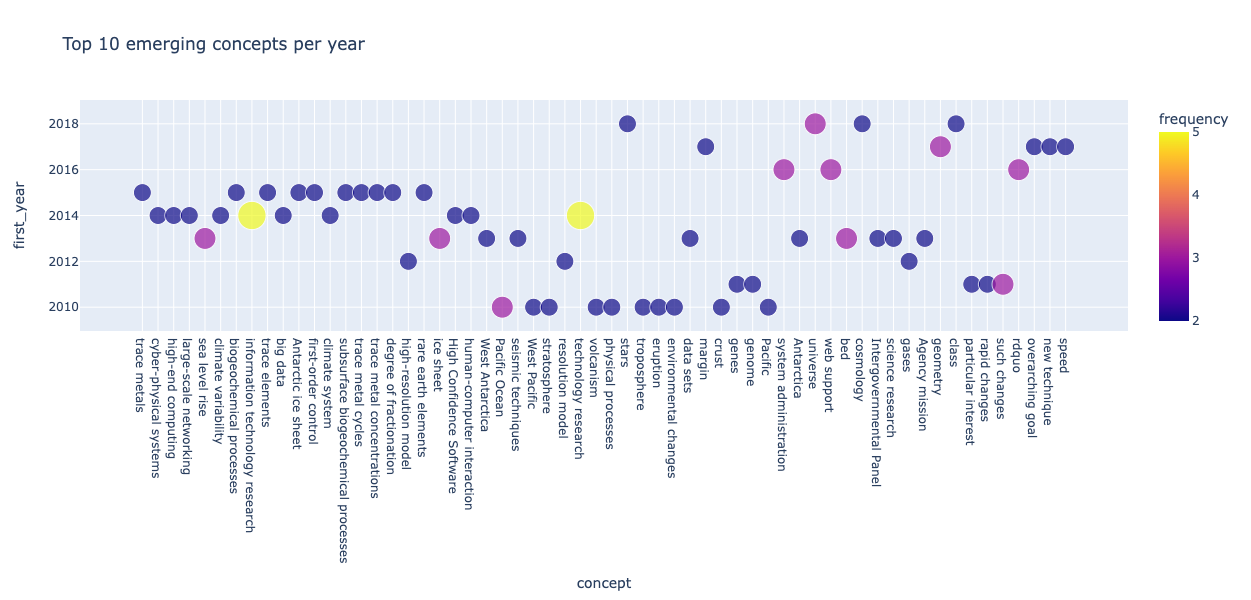

In [8]:
px.scatter(emerging_concepts,
           x="concept", y="first_year",
           color="frequency",
           size="frequency",
           height=600, 
           title=f"Top {CONCEPTS_PER_YEAR} emerging concepts per year")

## 5. Segmenting results using the fields of research categories

We can modify slightly the code in section 2 above so that the FOR categories are taken into consideration too.

You selected:
->200
->1-100000000
->0.6


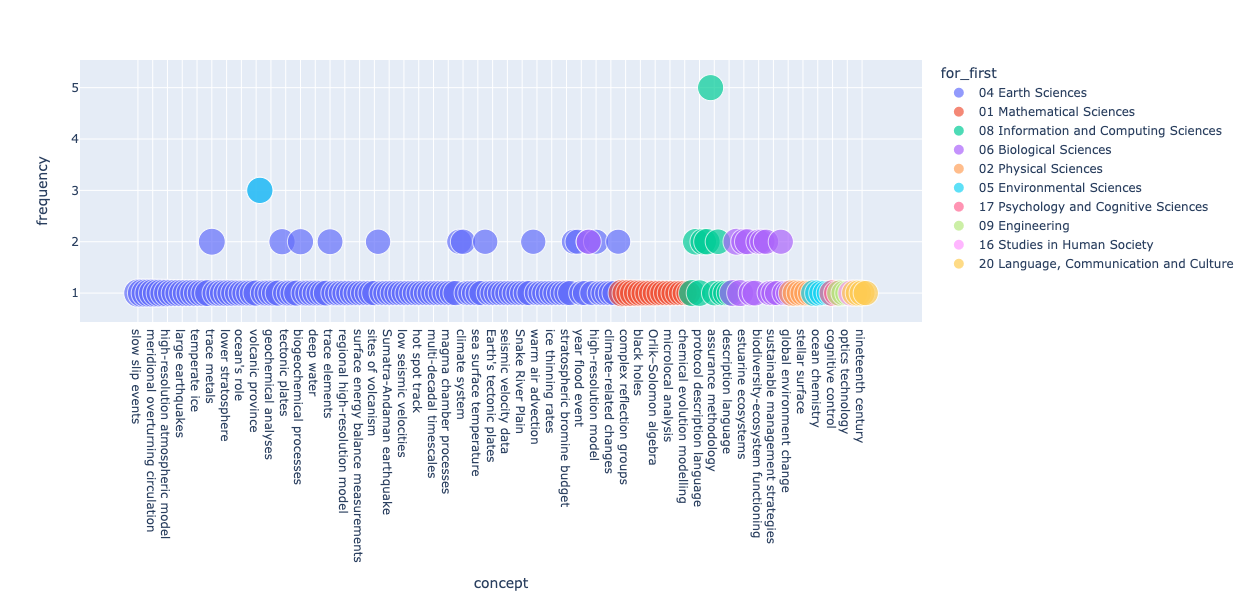

In [9]:
FREQ_MIN = 1 #@param {type: "slider", min: 1, max: 10, step:1}
FREQ_MAX = 100 #@param {type: "slider", min: 10, max: 100, step:10}

SCORE_MIN = 0.6  #@param {type: "slider", min: 0, max: 1, step:0.1}
#@markdown ---
#@markdown Select how many concepts to include in the visualization 
MAX_CONCEPTS = 200 #@param {type: "slider", min: 20, max: 1000, step:10}

if FREQ_MAX == 100:
  FREQ_MAX = 100000000
print(f"""You selected:\n->{MAX_CONCEPTS}\n->{FREQ_MIN}-{FREQ_MAX}\n->{SCORE_MIN}""") 

filtered_concepts = concepts_unique_in_for.query(f"""frequency >= {FREQ_MIN} & frequency <= {FREQ_MAX} & score_avg >= {SCORE_MIN} """)\
                    .sort_values(["score_avg", "frequency"], ascending=False)[:MAX_CONCEPTS]

px.scatter(filtered_concepts, 
           x="concept", 
           y="frequency", 
           height=600,
           color="for_first", 
           size="score_avg")


PS if you don't have too many categories, try using the `facet_col` option to see results side-to-side

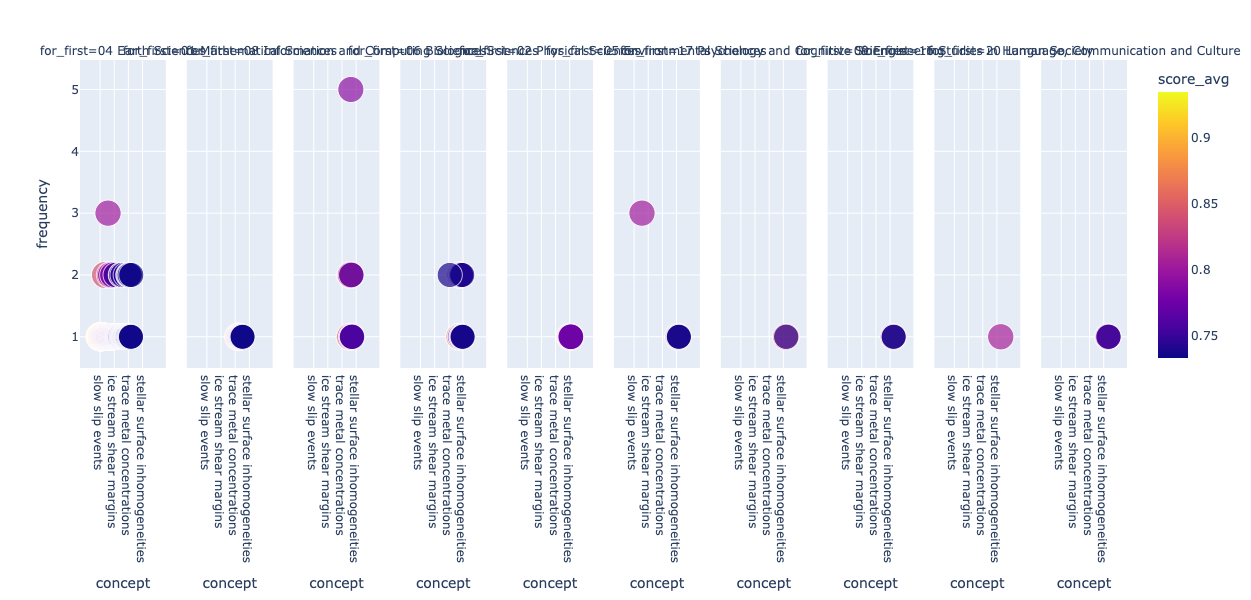

In [10]:
px.scatter(filtered_concepts, 
           x="concept", 
           y="frequency", 
           facet_col="for_first",
           height=600,
           color="score_avg", 
           size="score_avg")

## 6. Conclusion

In this tutorial we have demonstrated how to process grants *concepts* - normalised keywords found in documents- obtained using the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/). 

By playing with parameters like *frequency* and *average score*, it is possible to highlight interesting concepts programmatically and use them to carry out semantic analyses of the documents dataset they derive from. 

For more information on this topic, see also the [official documentation on concepts](https://docs.dimensions.ai/dsl/language.html#searching-using-concepts) and the [Working with concepts in the Dimensions API](https://api-lab.dimensions.ai/cookbooks/1-getting-started/7-Working-with-concepts.html) tutorial.